# Raster Data Workflows

*February 27, 2024*

**Today's lesson uses the following libraries (use `pip` to install them):**

```
numpy scipy matplotlib rasterio
```

**Today's lesson covers:**

- The `rasterio` library (imported `as rio`)
- Reading raster data files with `dataset = rio.open()`; the result is a `rasterio` Dataset
- Reading a raster band from a Dataset as a NumPy array: `dataset.read(1)`, where `1` is the band number
- Writing a NumPy array into a Dataset: `dataset.write(array, 1)`
- Project a raster array, using the tools: `from rasterio.warp import reproject, Resampling`
- Apply a moving-window operation using built-in focal operations: `from scipy.ndimage import maximum_filter`, or `from scipy.ndimage import median_filter`
- Apply a moving-window operation using a custom focal operation and `from scipy.ndimage import generic_filter`: `generic_filter(array, my_filter, size = 3)` where `my_filter` is a Python function you defined
- Modify the spatial resolution of an affine transformation: `new_transform = dataset.transform * dataset.transform.scale(y, x)` where `y` and `x` are the factors by which the old pixel height and width should be multiplied.

`rio.open()` has multiple uses:

- Opening a raster dataset to read from: `rio.open(filename, "r", ...)` where `"r"` indicates reading mode.
- Opening a raster dataset to write to: `rio.open(filename, "w", ...)` where `"w"` indicates writing mode.
- Opening a raster dataset not associated with a file, but in memory: `rio.open(filename, ..., driver = "MEM")`, where `filename` is arbitrary (could be a blank string)

`rio.read()` can be used to:

- Get a raster band as a NumPy array: `array = dataset.read(1)`
- Get a raster band as a NumPy array but with a different spatial resolution: `array = dataset.read(1, out_shape = (height, width), resampling = Resampling.nearest)`, where `1` is the band number, `width` and `height` are the desired shape in pixels.

## Introduction to `rasterio`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio

In [2]:
neon = rio.open('/vsicurl/http://files.ntsg.umt.edu/data/GIS_Programming/data/NEON_ortho.tif')
neon

<open DatasetReader name='/vsicurl/http://files.ntsg.umt.edu/data/GIS_Programming/data/NEON_ortho.tif' mode='r'>

In [5]:
# Tells us we're in 'read' or 'write' mode
neon.mode

'r'

In [7]:
# We can see how many bands are in the raster
neon.count

3

In [9]:
# Obtain raster height, width
neon.shape

(1000, 1000)

In [11]:
# Tells you how the bands are indexed
neon.indexes

(1, 2, 3)

In [12]:
# Retrieve dtypes following indexes
neon.dtypes

('uint8', 'uint8', 'uint8')

In [13]:
# Obtain the affine transformation
neon.transform

Affine(1.0, 0.0, 470000.0,
       0.0, -1.0, 7228000.0)

In [14]:
# Get the coordinates of the upper left corner
neon.transform * (0,0)

(470000.0, 7228000.0)

In [15]:
# Get the coordinates of the lower right corner
neon.transform * (1000, 1000) # Multiply by width and height

(471000.0, 7227000.0)

In [16]:
# Or you could multiply by the shape
(neon.transform * (1000,1000)) == (neon.transform * neon.shape)

True

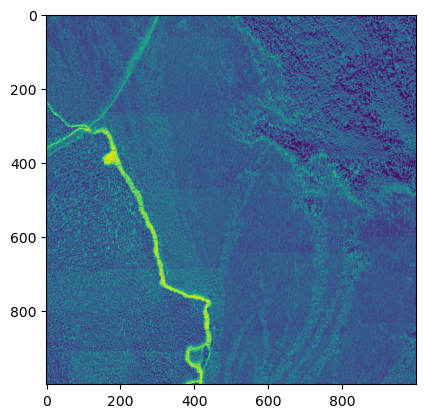

In [21]:
# Plot the first band
plt.imshow(neon.read(1))

### Writing Data with `rasterio`

In [22]:
# All these things normally are required to write with rasterio
dset = rio.open('rio_output.tif', 'w', driver = 'Gtiff', 
                height = 1000, width = 1000, count = 3,
                dtype = np.uint8, crs = neon.crs,
                transform = neon.transform)

In [23]:
dset.mode

'w'

In [25]:
# Arguments in file.write() are (Array, Band that you want to write the array to)
dset.write(neon.read(1), 1)
dset.close

<bound method DatasetBase.close of <open DatasetWriter name='rio_output.tif' mode='w'>>

---

## Reprojection and Resampling

#### NOTES:
- **RESAMPLING** means to recalculate values of a raster onto a new grid that may be of a different resolution or offset from the original
- **REPROJECTION** means figuring out how to change the spatial coordinates from one SRS to another, and how to resample the data to match the new SRS

In [3]:
ds_noaa = rio.open('/vsicurl/http://files.ntsg.umt.edu/data/GIS_Programming/data/NOAA_NCEP_CPC_gridded_deg0p5_2020-2021_mean.tiff')
ds_soc = rio.open('/vsicurl/http://files.ntsg.umt.edu/data/GIS_Programming/data/SPL4CMDL_Vv6040_20220901_SOC_9km.tiff')

In [27]:
# Create a temporary file
result = rio.open('temp.file', 'w+', driver = 'MEM', # The name doesn't matter, so we use 'temp.file'
                  width = 720, height = 360, count = 1, # Mode is 'w+' so we can write first and then read
                  dtype = np.int16, crs = ds_noaa.crs,
                  transform = ds_noaa.transform)

In [28]:
ds_soc.transform == ds_noaa.transform

False

In [29]:
ds_soc.transform

Affine(9000.0, 0.0, -17367530.45,
       0.0, -9000.0, 7314540.83)

In [30]:
ds_noaa.transform

Affine(0.5, 0.0, -179.75,
       0.0, -0.5, 89.75)

Source and destination must be either:
- numpy arrays
- rasterio.Band, which we can get using `rio.Band()`

In [31]:
# It appears that ds_noaa is in degrees and ds_soc is in meters
from rasterio.warp import reproject, Resampling

reproject(
    source = rio.band(ds_soc, 1), # Get the first band from ds_soc
    destination = rio.band(result, 1), # Write it to the first band of the result we just created
    resampling = Resampling.bilinear
)

(Band(ds=<open DatasetWriter name='temp.file' mode='w+'>, bidx=1, dtype='int16', shape=(360, 720)),
 None)

In [34]:
# We now store the temp file as an array
soc_11 = result.read(1)
soc_11.shape

(360, 720)

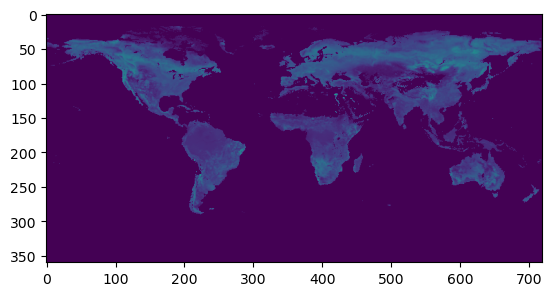

In [35]:
plt.imshow(soc_11)

### Resampling without Projection

#### Notes:

- **Downsampling**: going from fine to coarse
- **Upsampling**: going from coarse to fine

In [37]:
ds_soc.shape

(1624, 3856)

In [39]:
# This produces a numpy array 1/4 the size of the original
# It changes the pixel size to 4x larger
# The value of the larger pixel is the average value of the samller, merged pixels

soc_36km = ds_soc.read(
    out_shape = (ds_soc.height // 4, ds_soc.width // 4), resampling = Resampling.average)
soc_36km.shape

(1, 406, 964)

In [43]:
ds_soc.transform

Affine(9000.0, 0.0, -17367530.45,
       0.0, -9000.0, 7314540.83)

In [44]:
# Since soc_36km is just an array, it does not have an affine transform
# So we scale the transform of ds_soc by 4x to get the new_transform 
# This transform can now be applied to soc_36km
new_transform = ds_soc.transform * ds_soc.transform.scale(4, 4)
new_transform

Affine(36000.0, 0.0, -17367530.45,
       0.0, -36000.0, 7314540.83)

In [46]:
output = rio.open('resampled.tif', 'w', width = 964, height = 406, count = 1,
                  dtype = np.int16, crs = ds_soc.crs, transform = new_transform
                 )

---

## Moving-Window Functions

![](focal-operation.png)

*Image courtesy of [GISGeography](https://gisgeography.com/map-algebra-global-zonal-focal-local/)*

In [48]:
from scipy import ndimage

In [49]:
# The ndimage module within scipy has a lot of useful image processing algorithms

arr = np.random.randint(0, 4, size = 36).reshape((6,6))
arr

array([[2, 1, 1, 3, 0, 0],
       [2, 1, 2, 1, 0, 3],
       [0, 0, 3, 2, 2, 2],
       [2, 1, 2, 0, 3, 1],
       [2, 0, 0, 1, 3, 1],
       [1, 2, 3, 0, 2, 2]])

In [53]:
# This function applies a maximum filter to the input array, 
# replacing each element with the maximum value within a specified 
# neighborhood around that element.

ndimage.maximum_filter(arr, size = 3) # Size = 3 means a 3x3 square will be used

array([[2, 2, 3, 3, 3, 3],
       [2, 3, 3, 3, 3, 3],
       [2, 3, 3, 3, 3, 3],
       [2, 3, 3, 3, 3, 3],
       [2, 3, 3, 3, 3, 3],
       [2, 3, 3, 3, 3, 3]])

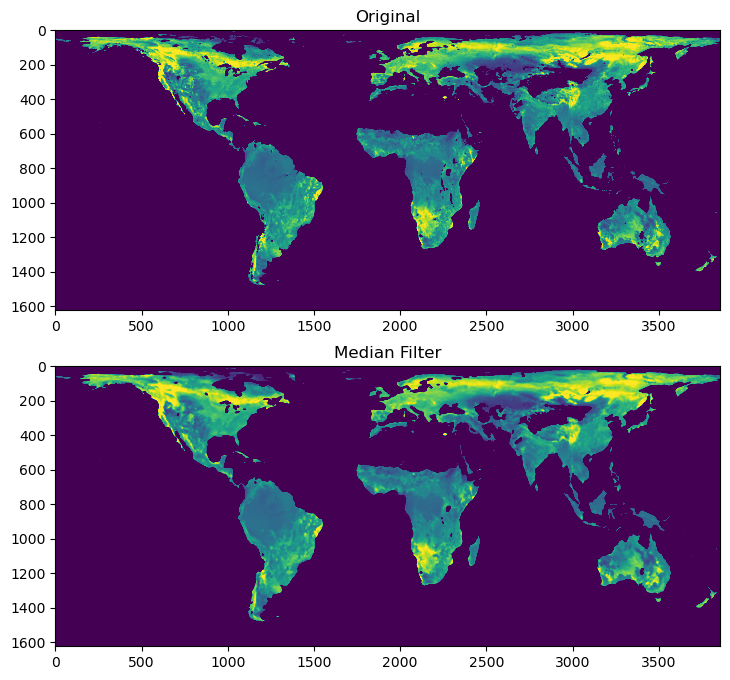

In [51]:
original = ds_soc.read(1)
filtered = ndimage.median_filter(original, size = 10)

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(2, 1, 1, title = 'Original')
ax.imshow(original, vmin = 0, vmax = 4000)
ax = fig.add_subplot(2, 1, 2, title = 'Median Filter')
ax.imshow(filtered, vmin = 0, vmax = 4000)

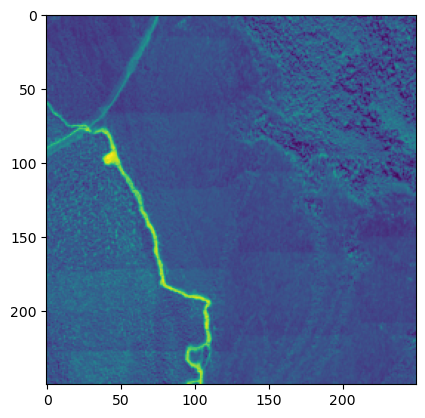

In [56]:
neon2 = neon.read(out_shape = (250,250), resampling = Resampling.bilinear)
plt.imshow(neon2[1])

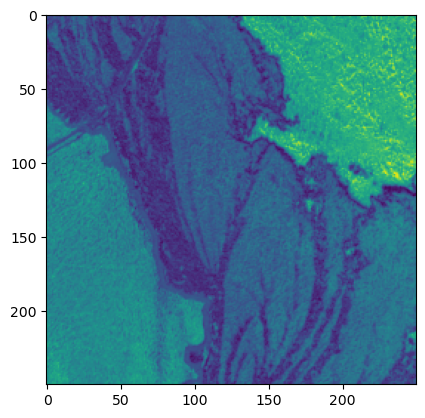

In [67]:
red = neon2[0].astype(np.float32) # Not sure what the rest of this code is
green = neon2[1].astype(np.float32)
ndgi = (green - red)/(green + red)
plt.imshow(ndgi)

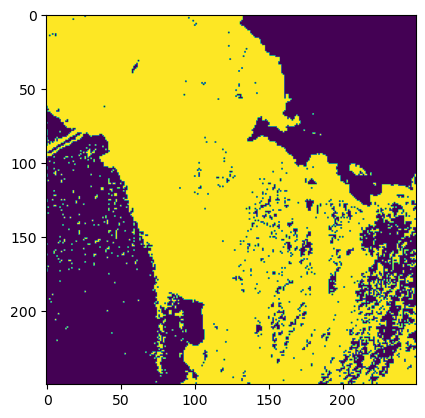

In [68]:
burned = ndgi < 100
burned = burned.astype(np.uint8)
plt.imshow(burned)

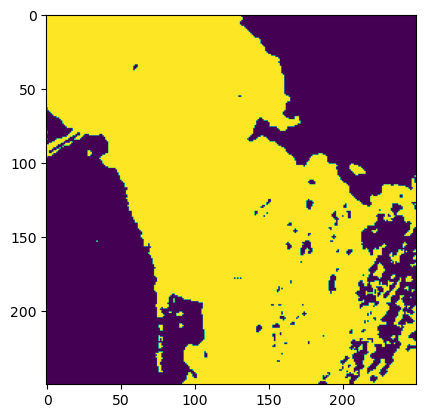

In [65]:
from scipy import stats

def majority_filter(window):
    return stats.mode(window)[0]

## Array, function, size of window
burned2 = ndimage.generic_filter(burned, majority_filter, size = 3)

plt.imshow(burned2)

In [62]:
# Consider an implementation of a function that considers a pixel around all the other pixels
# You can create a footprint to apply in your filter function

donut = np.ones((3,3))
donut[1,1] = 0
donut

array([[1., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.]])

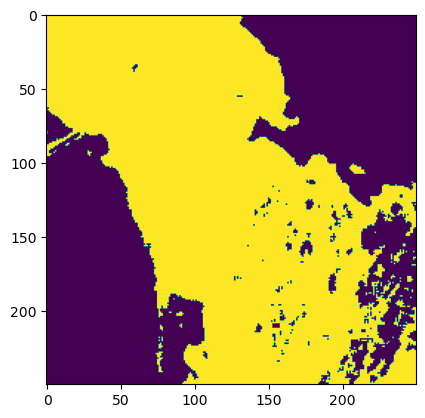

In [66]:
burned3 = ndimage.generic_filter(burned, majority_filter, footprint = donut)
plt.imshow(burned3)

---

# More Resources

- [Reprojection - rasterio documentation](https://rasterio.readthedocs.io/en/latest/topics/reproject.html)